In [1]:
%pip install polars matplotlib numpy pandas seaborn scikit-learn pyarrow biopython ete3 PyQt5
import polars as pl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import re
from Bio import SeqIO
from matplotlib import gridspec
import string
from ete3 import Tree, TreeStyle
import PyQt5

sns.set_theme(context="paper")

Note: you may need to restart the kernel to use updated packages.


Begin by comparing the Earlgrey and EDTA libraries. Which is better??? Lets foind out!!

Use gff and fasta library files to get some summary stats going

In [6]:
# get earlgrey family sizes
ids, sizes = [], []
with open("../results/earlgrey/solanum_verrucosum_summaryFiles/solanum_verrucosum-families.fa.strained") as file:
    for record in SeqIO.parse(file, "fasta"):
        ids.append(record.id)
        sizes.append(len(record.seq))

earlgrey_te_library = pl.DataFrame(
    {
        "id": ids,
        "size": sizes
    }
)

earlgrey_te_library = (
    earlgrey_te_library
    .with_columns(
        (pl.col("id").str.extract(r"^(.*?)#(.*?)(?:/(.*))?$", 1)).alias("family"),
        (pl.col("id").str.extract(r"^(.*?)#(.*?)(?:/(.*))?$", 2)).alias("classification"),
        (pl.col("id").str.extract(r"^(.*?)#(.*?)(?:/(.*))?$", 3)).alias("subfamily"),
        (pl.lit("earlgrey")).alias("source"),
    )
)

earlgrey_gff = (
    pl.read_csv(
        "../results/earlgrey/solanum_verrucosum_summaryFiles/solanum_verrucosum.filteredRepeats.gff",
        separator="\t",
        has_header=False,
    )
    .with_columns(
        (pl.col("column_9").str.extract(r"ID=(.*?);")).str.to_lowercase().alias("family"),
        (pl.col("column_5") - pl.col("column_4")).alias("length"),
    )
)

earlgrey_coverage = (
    earlgrey_gff
    .group_by("family")
    .agg(pl.sum("length").alias("total_coverage"))
)

ids, sizes = [], []
with open("../results/edta/final_assembly.fa.mod.EDTA.TElib.fa") as file:
    for record in SeqIO.parse(file, "fasta"):
        ids.append(record.id)
        sizes.append(len(record.seq))

edta_te_library = pl.DataFrame(
    {
        "id": ids,
        "size": sizes
    }
)

edta_te_library = (
    edta_te_library
    .with_columns(
        (pl.col("id").str.extract(r"^(.*?)#(.*?)(?:/(.*))?$", 1)).alias("family"),
        (pl.col("id").str.extract(r"^(.*?)#(.*?)(?:/(.*))?$", 2)).alias("classification"),
        (pl.col("id").str.extract(r"^(.*?)#(.*?)(?:/(.*))?$", 3)).alias("subfamily"),
        (pl.lit("edta")).alias("source"),
    )
)

edta_gff = (
    pl.read_csv(
        "../results/edta/final_assembly.fa.mod.EDTA.TEanno.gff3",
        separator="\t",
        has_header=False,
        comment_prefix="#"
    )
    .with_columns(
        (pl.col("column_9").str.extract(r"Name=(.*?);")).alias("family"),
        (pl.col("column_5") - pl.col("column_4")).alias("length")
    )
)

edta_coverage = (
    edta_gff
    .group_by("family")
    .agg(pl.sum("length").alias("total_coverage"))
)

earlgrey_te_library = (
    earlgrey_te_library
    .join(earlgrey_coverage, on="family", how="left")
)

edta_te_library = (
    edta_te_library
    .join(edta_coverage, on="family", how="left")
)

te_library = pl.concat([earlgrey_te_library, edta_te_library])

# Need to make some sensible TE classification naming suitable for both
# LTR, LINE, SINE, DNA, Helitron, Other, Unknown
# Helitron classifications are at the subfamily level
te_library = (
    te_library
    .with_columns(
        pl.when(pl.col("classification").str.contains("Satellite")).then(pl.lit("Other"))
        .when(pl.col("classification").str.contains("Simple_repeat")).then(pl.lit("Other"))
        .when(pl.col("classification").str.contains("snRNA")).then(pl.lit("Other"))
        .when(pl.col("classification").str.contains("tRNA")).then(pl.lit("Other"))
        .when(pl.col("classification").str.contains("rRNA")).then(pl.lit("Other"))
        .when(pl.col("classification").str.contains("MITE")).then(pl.lit("Other"))
        .otherwise(pl.col("classification"))
        .alias("neat_classification"),
    )
    .with_columns(
        pl.when(pl.col("subfamily").str.contains("Helitron")).then(pl.col("subfamily"))
        .otherwise(pl.col("neat_classification"))
        .alias("neat_classification"),
    )
)

/var/folders/v0/ly538751577dz0fqnlb8rj9m0000gn/T/ipykernel_51000/228588402.py:86: DeprecationWarning: The default coalesce behavior of left join will change to `False` in the next breaking release. Pass `coalesce=True` to keep the current behavior and silence this warning.
  earlgrey_te_library
/var/folders/v0/ly538751577dz0fqnlb8rj9m0000gn/T/ipykernel_51000/228588402.py:91: DeprecationWarning: The default coalesce behavior of left join will change to `False` in the next breaking release. Pass `coalesce=True` to keep the current behavior and silence this warning.
  edta_te_library


In [9]:
te_library.filter(pl.col("subfamily") == "crm")

id,size,family,classification,subfamily,source,total_coverage,neat_classification
str,i64,str,str,str,str,i64,str


Visual comparison of TE libraries...

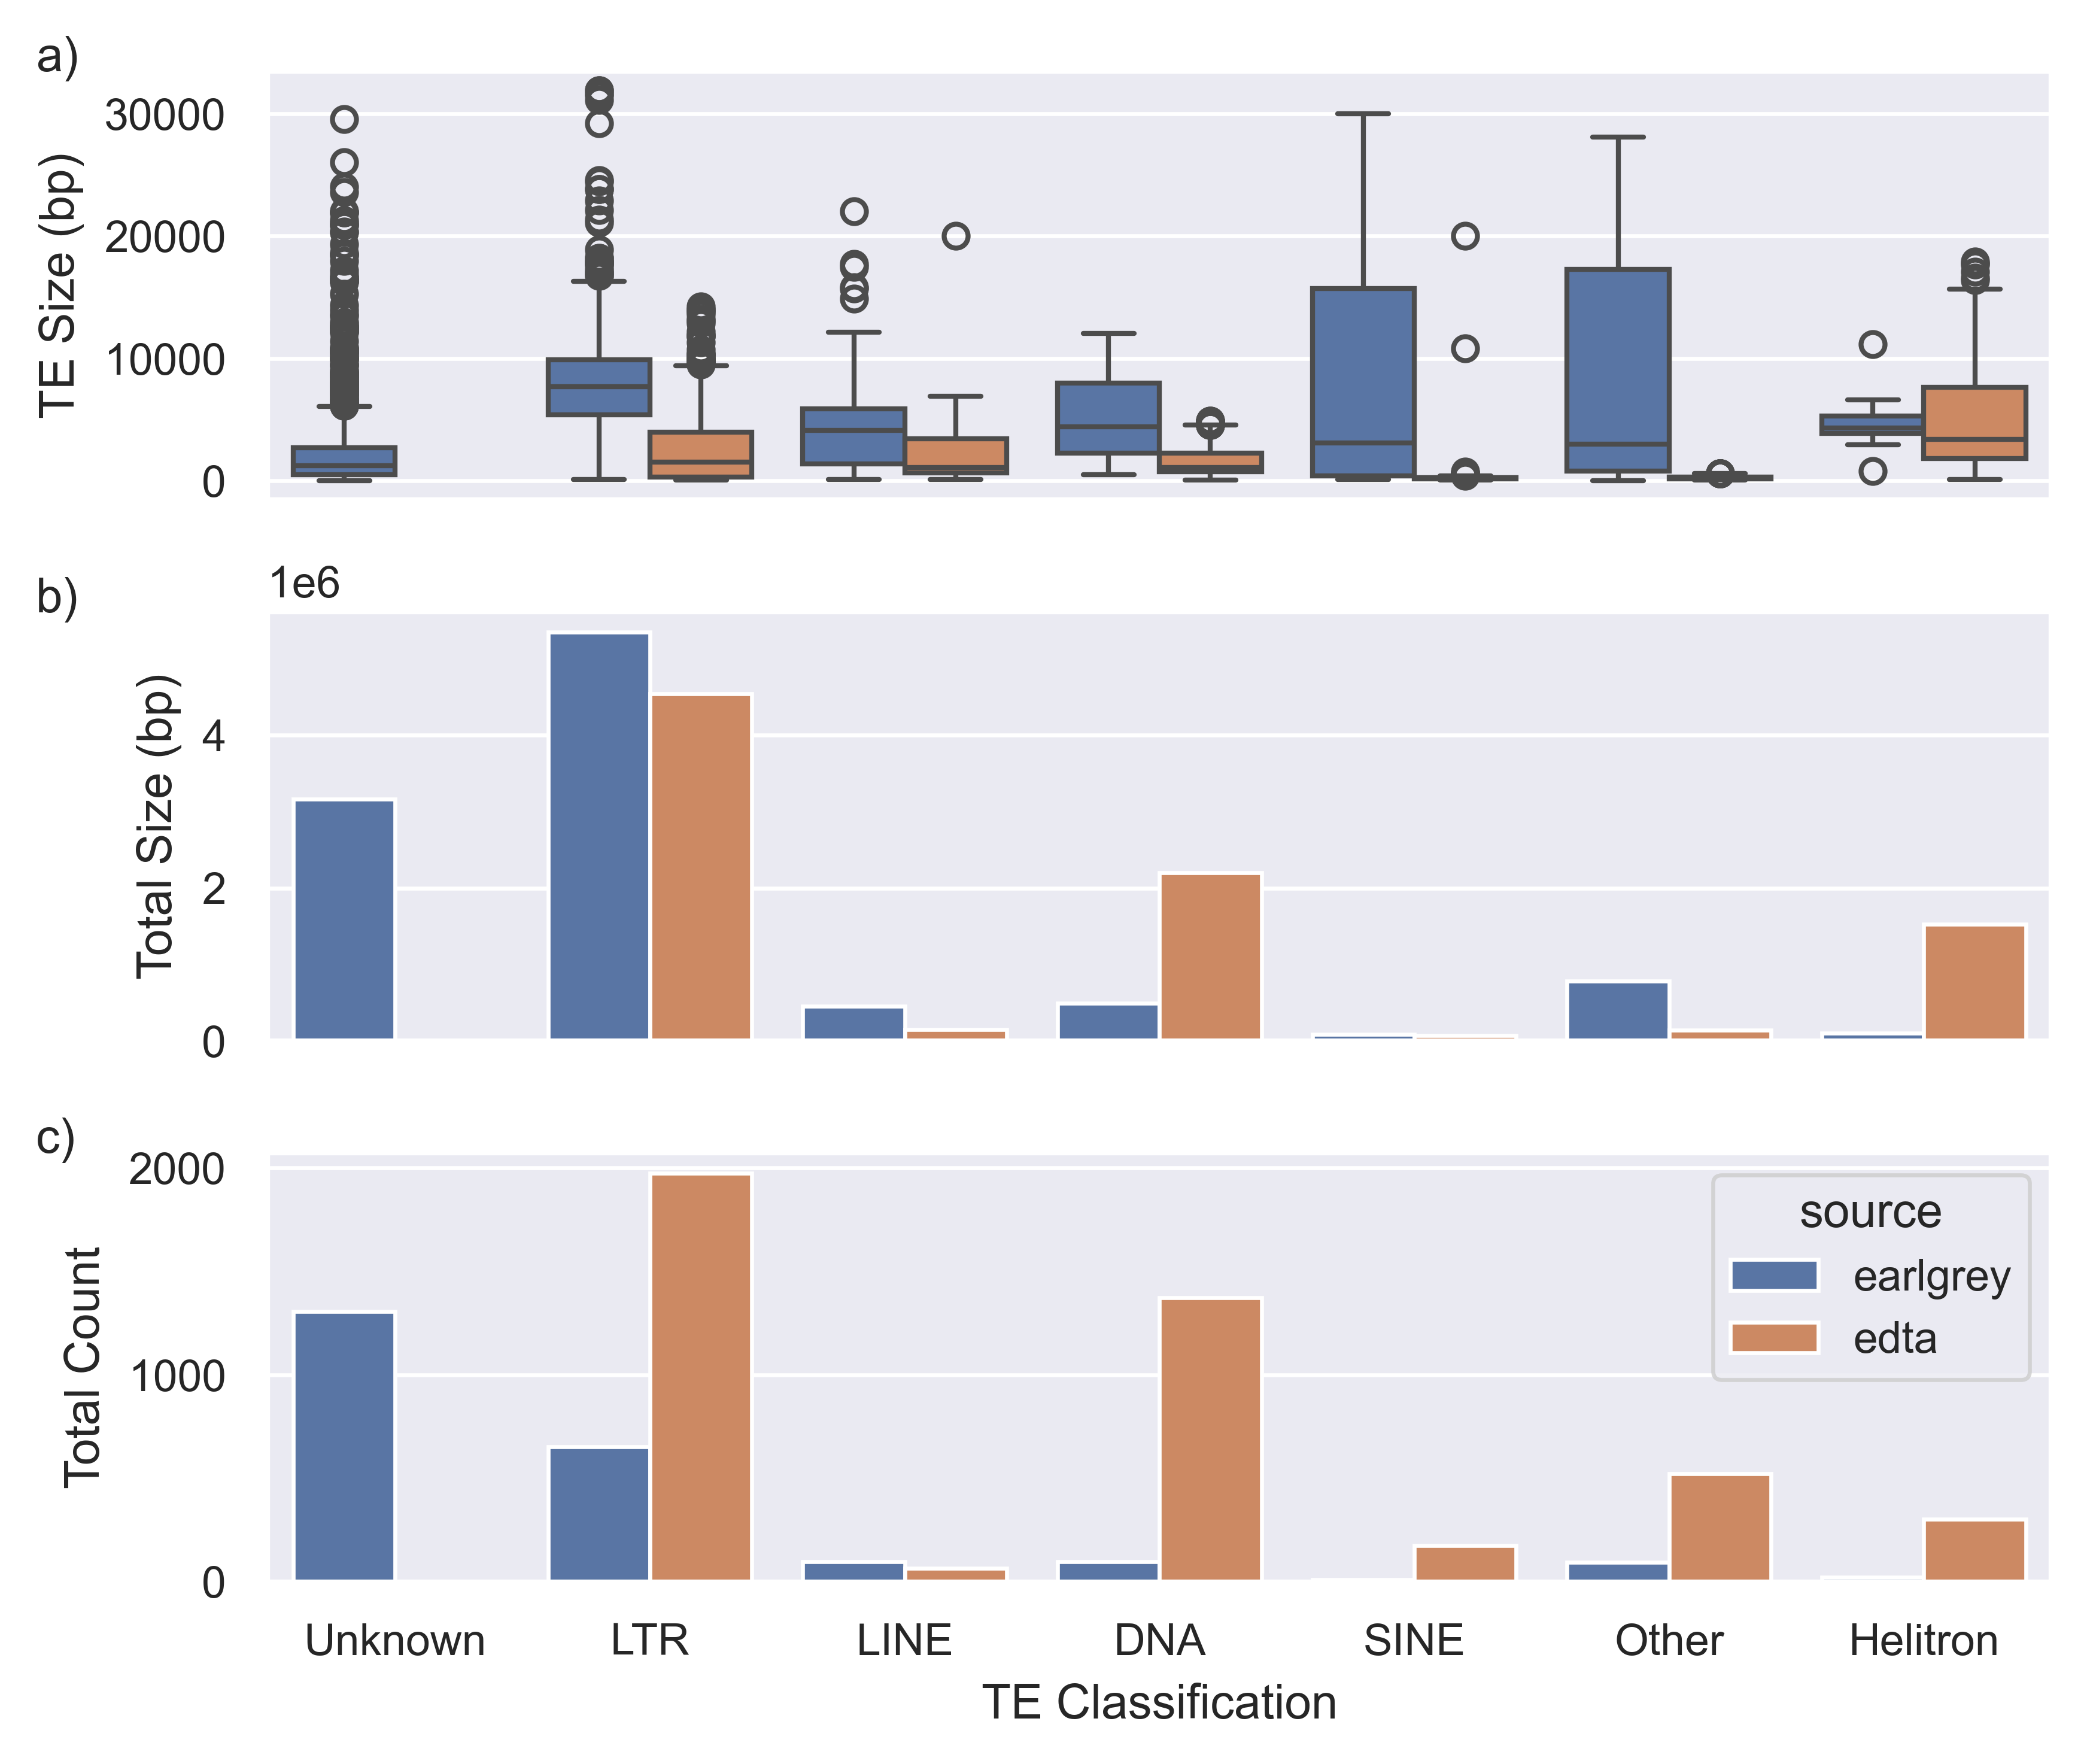

In [3]:
fig, axes = plt.subplots(
    figsize=(5.9, 5),
    nrows=3,
    sharex="col",
    layout="tight",
    dpi=600
)

sns.boxplot(
    te_library.sort("source"),
    x="neat_classification",
    y="size",
    hue="source",
    ax=axes[0],
)

axes[0].set_ylabel("TE Size (bp)")
axes[0].get_legend().remove()

sns.barplot(
    (
        te_library
        .group_by("neat_classification", "source")
        .agg(pl.sum("size").alias("total_size"))
        .sort("source")
    ),
    x="neat_classification",
    y="total_size",
    hue="source",
    ax=axes[1],
)


axes[1].set_ylabel("Total Size (bp)")
axes[1].get_legend().remove()

sns.barplot(
    (
        te_library
        .group_by("neat_classification", "source")
        .agg(pl.count("size").alias("total_count"))
        .sort("source")
    ),
    x="neat_classification",
    y="total_count",
    hue="source",
    ax=axes[2],
)

axes[2].set_ylabel("Total Count")
axes[2].set_xlabel("TE Classification")

for n, ax in enumerate(axes):
    ax.text(
        -0.13,
        1,
        f"{string.ascii_lowercase[n]})",
        transform=ax.transAxes,
    )

fig.savefig("../../pandoc-thesis/figures/te_library_comparison.png")


!! Only run this code on the cluster !! OTHERWISE THINGS GO UP IN SMOKE

In [98]:
methylation_df = pl.read_csv(
    "../results/deepsignal/te_matrix.tab",
    separator = "\t",
    comment_prefix = "@",
    has_header = False
)

methylation_df = methylation_df.drop("column_1", "column_2", "column_3", "column_5", "column_6")
new_column_names = ["id"] + [f"{type}:{i}" for type in ["CG", "CHG", "CHH"] for i in range(1,601)]
methylation_df = methylation_df.rename(dict(zip(methylation_df.columns, new_column_names)))


# Use the Earlgrey GFF file to translate the keys used by deeptools into something more useful.
earlgrey_gff = (
    pl.read_csv(
        "../results/earlgrey/solanum_verrucosum_EarlGrey/solanum_verrucosum_summaryFiles/solanum_verrucosum.filteredRepeats.gff",
        separator = "\t",
        has_header = False
    )
    .with_columns(
        [
            (pl.concat_str(
                pl.col("column_1"),
                pl.concat_str(
                    pl.col("column_4"),
                    pl.col("column_5"),
                    separator = "-"
                ),
                separator = ":")
            .alias("id")),
            (pl.col("column_9").str.extract(r"ID=(.*?);").alias("family"))
        ]
    )
    .select(["id", "family", "column_3"])
)

# Join datasets
methylation_df = methylation_df.join(earlgrey_gff, on = "id", how = "inner")

# Convert to long format
methylation_df = methylation_df.melt(id_vars = ["id", "family", "column_3"], variable_name = "position", value_name = "methylation")

# Split the position column into two columns
methylation_df = methylation_df.with_columns([
    pl.col("position")
    .str.split_exact(":", 1)
    .struct.rename_fields(["type", "Position"])
    .alias("fields"),
    ]
).unnest("fields")

summary_df = (
    methylation_df.select(
        pl.col("column_3").alias("te_type"),
        pl.col("type"),
        pl.col("Position").cast(pl.Int32),
        pl.col("methylation").cast(pl.Float32)
    )
    .group_by(["te_type", "type", "Position"])
    .agg(pl.col("methylation").drop_nans().mean())
)

summary_df.write_csv("../results/te_methylation_summary.csv")

# Calculate the mean body methylation for each family
body_methylation_df = (
    methylation_df.select(
        pl.col("family"),
        pl.col("type"),
        pl.col("Position").cast(pl.Int32),
        pl.col("methylation").cast(pl.Float32)
    )
    .filter((pl.col("Position") >= 200) & (pl.col("Position") < 400))
    .group_by(["family", "type"])
    .agg(pl.col("methylation").drop_nans().mean())
)

body_methylation_df.write_csv("../results/te_body_methylation_summary.csv")


<Axes: xlabel='methylation', ylabel='Count'>

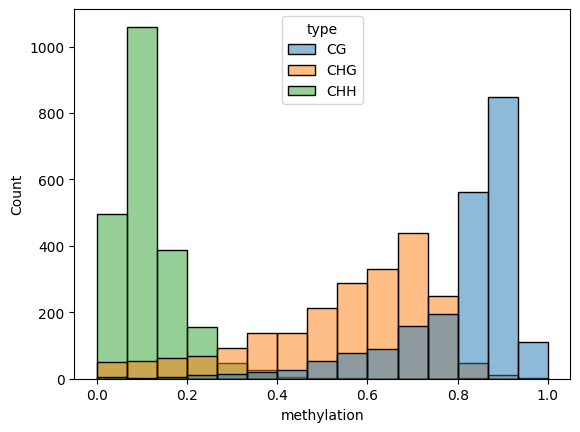

In [13]:
body_methylation_df = pl.read_csv("../results/te_body_methylation_summary.csv")

# filter out anything that doesn't follow the syntax of "RND-..."
body_methylation_df = body_methylation_df.filter(pl.col("family").str.contains(r"RND-"))

sns.histplot(
    body_methylation_df,
    x = "methylation",
    hue = "type",
)

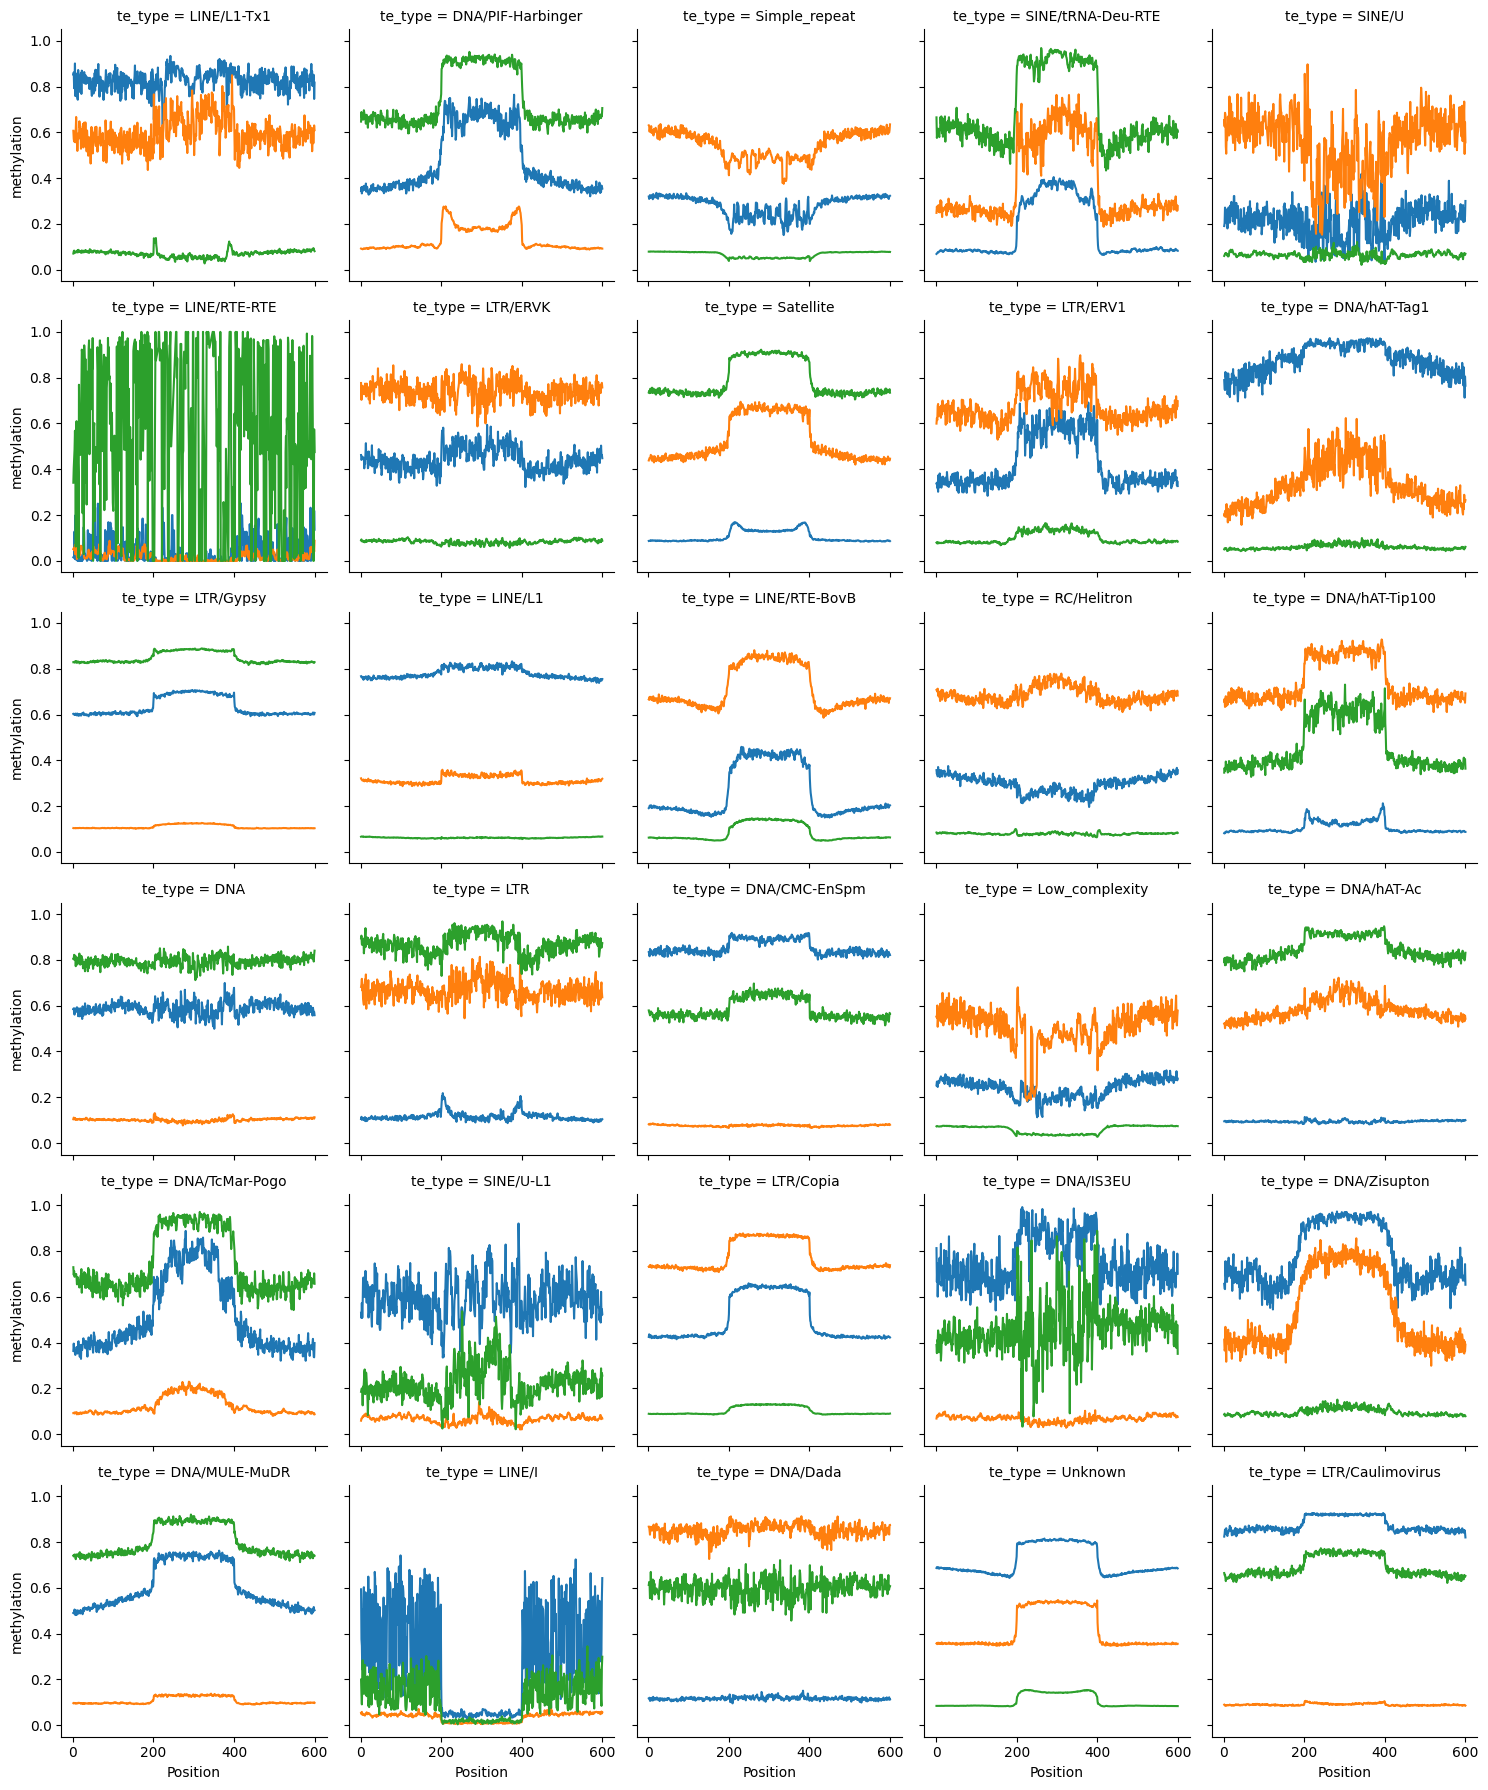

In [7]:

summary_df = pl.read_csv("../results/te_methylation_summary.csv")

plot = sns.FacetGrid(
    summary_df,
    col = "te_type",
    col_wrap = 5,
)
plot.map(
    sns.lineplot,
    "Position",
    "methylation",
    "type",
)
plot.savefig(
    "../results/te_methylation_summary.png",
    
)

In [4]:
earlgrey = pl.read_csv(
    "../results/earlgrey/solanum_verrucosum_summaryFiles/solanum_verrucosum.filteredRepeats.gff",
    separator = "\t",
    has_header = False
)